## Импорты

In [1]:
import pandas as pd
import numpy as np
import sklearn
import xgboost as xgb
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier

from user_agents import parse

import datetime

%pylab inline

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Populating the interactive namespace from numpy and matplotlib


## Объявления полезных функций

In [2]:
def log_mes(mes):
    """Выводит таймстемп и переданное сообщение"""
    print(datetime.datetime.now().strftime("%H:%M:%S %d.%m.%Y"), mes)

## Чтение выгрузки

In [3]:
metabase_unload = pd.read_csv('unloads/unload.csv', delimiter=",")

In [4]:
# Юзер-агент пока не использую, т.к. он очень долго анализируется
# metabase_unload['device'] = metabase_unload.apply(lambda x: parse(x['user_agent']).device if pd.isnull(x['user_agent']) == False else "None", axis=1)
# metabase_unload['os_version'] = metabase_unload.apply(lambda x: parse(x['user_agent']).os.version if pd.isnull(x['user_agent']) == False else "None", axis=1)
metabase_unload = metabase_unload.drop('user_agent', axis=1)

In [5]:
metabase_unload.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048576 entries, 0 to 1048575
Data columns (total 19 columns):
user_id                           1048576 non-null int64
has_paid                          1048576 non-null int64
reg_page                          983876 non-null object
reason                            107570 non-null float64
teacher                           107570 non-null float64
time                              107570 non-null float64
best_statement                    107570 non-null float64
signed_up_on_weekend_day          1048576 non-null int64
signed_up_at_night_interval       1048576 non-null int64
source_group_id                   1048576 non-null int64
grade_id                          1048576 non-null int64
has_birth_date                    1048576 non-null int64
is_parent                         1048576 non-null int64
has_phone                         1048576 non-null int64
phone_confirmed                   1048576 non-null int64
address_entered_before_payme

## Бинаризация категориальных признаков

In [6]:
CATEGORY_COL = ['grade_id']
metabase_unload = pd.get_dummies(metabase_unload, columns=CATEGORY_COL, drop_first=True)

## Разделение пользователей на московских и региональных

In [7]:
metabase_unload_moscow = metabase_unload.where(metabase_unload["is_moscow_school"] == True, axis=1)\
                                        .drop(['is_moscow_school'], axis=1)\
                                        .dropna(subset=['user_id'])
metabase_unload_regions = metabase_unload.where(metabase_unload["is_moscow_school"] == False, axis=1)\
                                        .drop(['is_moscow_school'], axis=1)\
                                        .dropna(subset=['user_id'])

## Поиск соответствий для московских школ для получения результатов ЕГЭ

В открытых данных информация о школах представлена в двух файлах:
* общая информация о школах (реквизиты, название, контакты и пр.)
* информация о результатах ЕГЭ.
В обоих файлах есть ОГРН, по которому можно сджоинить школы для получения единой таблицы.

В базе заказчика информации о школах крайне мало, но, на удивление, есть контакты: телефон, электронная почта и сайт. Все эти три поля присутствуют и в открытых данных, поэтому для джоина открытых данных и школ из базы буду использовать именно контактную информацию


In [8]:
# читаем общую информацию
data_mos_ru_moscow_schools = pd.read_csv('unloads/data_mos_ru_moscow_schools.csv', delimiter=";")
data_mos_ru_moscow_schools.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 696 entries, 0 to 695
Data columns (total 22 columns):
Сокращённое наименование                            696 non-null object
Полное наименование                                 696 non-null object
Лицензирование и аккредитация                       696 non-null object
Образовательные услуги                              606 non-null object
Статус организации                                  696 non-null object
Код ЕКИС ОУ                                         696 non-null int64
Номер ОУ                                            604 non-null float64
Адреса учреждения                                   693 non-null object
ИНН                                                 696 non-null int64
КПП                                                 696 non-null int64
ОГРН                                                696 non-null int64
Организационно-правовая форма                       696 non-null object
Подчинение                        

In [9]:
# читаем результаты ЕГЭ
data_mos_ru_ege_results = pd.read_csv('unloads/data_mos_ru_ege_results.csv', delimiter=";")
data_mos_ru_ege_results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 626 entries, 0 to 625
Data columns (total 14 columns):
signature_date        626 non-null object
system_object_id      626 non-null int64
global_id             626 non-null int64
ID                    626 non-null int64
AdmArea               626 non-null object
District              626 non-null object
EDU_NAME              626 non-null object
OGRN                  626 non-null int64
PASSED_NUMBER_FULL    626 non-null int64
PASSES_OVER_220       626 non-null int64
PASSER_UNDER_160      626 non-null int64
YEAR                  626 non-null object
LINK                  626 non-null object
Unnamed: 13           0 non-null float64
dtypes: float64(1), int64(7), object(6)
memory usage: 68.5+ KB


In [10]:
# собираем открытые данные в одну таблицу
rename_map = {'Контактный телефон':'phone', 
              'Адрес электронной почты':'email', 
              'Сайт': 'website',
              'Сокращённое наименование': 'short_name',
              'Полное наименование': 'full_name'}
data_mos_ru_ege_results_merged = data_mos_ru_moscow_schools\
    .merge(data_mos_ru_ege_results, left_on='ОГРН', right_on='OGRN')\
    .rename(columns=rename_map)\
    [['short_name', 'full_name', 'phone', 'email', 'website', 'PASSED_NUMBER_FULL', 'PASSES_OVER_220', 'PASSER_UNDER_160']]

# рассчитываем доли самых успешных учеников и учеников "непровалившихся" на ЕГЭ
data_mos_ru_ege_results_merged['passes_over_220_share'] = \
    data_mos_ru_ege_results_merged.apply(lambda x: x['PASSES_OVER_220']/x['PASSED_NUMBER_FULL'], axis=1)
data_mos_ru_ege_results_merged['passes_over_160_share'] = \
    data_mos_ru_ege_results_merged.apply(lambda x: x['PASSER_UNDER_160']/x['PASSED_NUMBER_FULL'], axis=1)
data_mos_ru_ege_results_merged = data_mos_ru_ege_results_merged.drop(['PASSED_NUMBER_FULL', 'PASSES_OVER_220', 'PASSER_UNDER_160'], axis = 1)

# форматируем номер телефона для поиска школы в данных заказчика
data_mos_ru_ege_results_merged['phone'] = data_mos_ru_ege_results_merged.apply(lambda x: x['phone']\
                                                                               .replace('(','')\
                                                                               .replace(')', '')\
                                                                               .replace('-', '')\
                                                                               .replace(' ', ''), axis=1)
data_mos_ru_ege_results_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 606 entries, 0 to 605
Data columns (total 7 columns):
short_name               606 non-null object
full_name                606 non-null object
phone                    606 non-null object
email                    606 non-null object
website                  606 non-null object
passes_over_220_share    606 non-null float64
passes_over_160_share    606 non-null float64
dtypes: float64(2), object(5)
memory usage: 37.9+ KB


In [11]:
# Читаем выгрузка информации о школах из базы заказчика
metabase_moscow_schools = pd.read_csv('unloads/moscow_schools.csv', delimiter=",", dtype={'phone': str})
metabase_moscow_schools.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1179 entries, 0 to 1178
Data columns (total 5 columns):
id         1179 non-null int64
name       1179 non-null object
email      971 non-null object
phone      973 non-null object
website    1042 non-null object
dtypes: int64(1), object(4)
memory usage: 46.1+ KB


In [12]:
# джоин открытых данных к информации из базы заказчика
metabase_moscow_schools['key'] = 1
data_mos_ru_ege_results_merged['key'] = 1

moscow_schools = metabase_moscow_schools.merge(data_mos_ru_ege_results_merged, on='key')
moscow_schools = moscow_schools\
                    .where((moscow_schools['phone_x'] == moscow_schools['phone_y']) 
                         | (moscow_schools['email_x'] == moscow_schools['email_y']) 
                         | (moscow_schools['website_x'] == moscow_schools['website_y']))\
                    .dropna(subset=['id'])
moscow_schools = moscow_schools[['id', 'passes_over_220_share', 'passes_over_160_share']]      

moscow_schools.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 531 entries, 834 to 712246
Data columns (total 3 columns):
id                       531 non-null float64
passes_over_220_share    531 non-null float64
passes_over_160_share    531 non-null float64
dtypes: float64(3)
memory usage: 16.6 KB


In [13]:
# джоин результатов ЕГЭ к пользователям из московских школ
metabase_unload_moscow = metabase_unload.merge(moscow_schools, left_on='school_id', right_on='id', how='left').drop(['id', 'school_id'], axis=1)
metabase_unload_moscow.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1048576 entries, 0 to 1048575
Data columns (total 30 columns):
user_id                           1048576 non-null int64
has_paid                          1048576 non-null int64
reg_page                          983876 non-null object
reason                            107570 non-null float64
teacher                           107570 non-null float64
time                              107570 non-null float64
best_statement                    107570 non-null float64
signed_up_on_weekend_day          1048576 non-null int64
signed_up_at_night_interval       1048576 non-null int64
source_group_id                   1048576 non-null int64
has_birth_date                    1048576 non-null int64
is_parent                         1048576 non-null int64
has_phone                         1048576 non-null int64
phone_confirmed                   1048576 non-null int64
address_entered_before_payment    1048576 non-null int64
region_id                   

### Удалось определить результаты ЕГЭ для 531 школы из 1179

## Обучение и запуск модели

In [14]:
def count_woe(X_train, X_test, column_name):
    """Считает woe по train'у и подставляет рассчитанные значения в train и в test"""
    
    threshold = 100
    fillna=True
    
    # расчет общего количества положительных и отрицательных событий
    paid_size = len(X_train[X_train['has_paid'] == 1])
    not_paid_size = len(X_train[X_train['has_paid'] == 0])
    
    # имя колонки, в которую будет помещен результат расчета
    woe_column_name = column_name + '_woe'
    
    # расчет общего количества пользователей и количества положительных событий для каждой категории
    woe_ds = X_train\
        .groupby([column_name])\
        .agg({'user_id':'size', 'has_paid':'sum'})\
        .reset_index()\
        .rename(columns={'user_id':'total'})

    # отсекаем категории, в которых количество пользователей не превышает 100 и категории, 
    # в которых нет ни одного положительного события
    woe_ds = woe_ds[(woe_ds['total'] > threshold) & (woe_ds['has_paid'] > 0)]
    
    # расчитываем количество отрицательных событий для каждой из категорий
    woe_ds['has_not_paid'] = woe_ds.apply(lambda x: x.total - x.has_paid, axis=1)
    
    # рассчитываем WOE
    woe_ds[woe_column_name] = woe_ds\
        .apply(lambda x: math.log((x.has_paid/paid_size)/(x.has_not_paid/not_paid_size)), axis=1)
    
    # удаляем промежуточные колонки для расчета
    woe_ds = woe_ds.drop(['has_paid', 'has_not_paid', 'total'], axis=1)
    
    # джоиним результаты
    X_train = X_train.merge(woe_ds, how='left', left_on=column_name, right_on=column_name)
    X_test = X_test.merge(woe_ds, how='left', left_on=column_name, right_on=column_name)
    
    # заполняем незаполненные значения медианами
    if fillna:
        median = np.median(X_train[woe_column_name].dropna())
        X_train[woe_column_name] = X_train[woe_column_name].fillna(median)
        X_test[woe_column_name] = X_test[woe_column_name].fillna(median)
        
    return X_train.drop(column_name, axis=1), X_test.drop(column_name, axis=1)

In [15]:
def modelPipeline(preparedTable):
    """
    Функция выделяет целевую переменную, делит выборку на трейн и тест,
    взвешивает данные, обучает модель и делает предсказание
    """
    
    # Выделяем целевую переменную
    y = preparedTable['has_paid']
    X = preparedTable
    
    # Делим на train и test
    X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Считаем woe-колонки
    woe_columns = ['source_group_id', 'region_id', 'reg_page', 'reason', 'teacher', 'time', 'best_statement']
    for column in woe_columns:
        X_train, X_test = count_woe(X_train, X_test, column)    
    
    # Удаляем лишние колонки
    cols_to_drop = ['has_paid', 'user_id']
    X_train = X_train.drop(cols_to_drop, axis = 1)
    X_test = X_test.drop(cols_to_drop, axis = 1)
    
    # Подготовим веса
    paid_size = len(preparedTable[preparedTable['has_paid'] == 1])
    not_paid_size = len(preparedTable[preparedTable['has_paid'] == 0])

    paid_weight = not_paid_size/paid_size
    weights = y_train.apply(lambda x: 1 if x == 0 else paid_weight)

    # Модель
    model = xgb.XGBClassifier()
    model.fit(X_train, y_train, sample_weight=weights)

    # Предсказание
    y_pred = model.predict_proba(X_test)
    
    return y_pred, y_test

In [16]:
log_mes('Начало Регионы')
y_pred_regions, y_test_regions = modelPipeline(metabase_unload_regions)
log_mes('Конец Регионы')

22:18:09 14.11.2017 Начало Регионы
22:18:57 14.11.2017 Конец Регионы


In [17]:
log_mes('Начало Москва с учетом ЕГЭ')
y_pred_moscow_with_ege_results, y_test_moscow_with_ege_results = modelPipeline(metabase_unload_moscow)
log_mes('Конец Москва с учетом ЕГЭ')

22:18:57 14.11.2017 Начало Москва с учетом ЕГЭ
22:19:46 14.11.2017 Конец Москва с учетом ЕГЭ


In [18]:
log_mes('Начало Москва без учета ЕГЭ')
metabase_unload_moscow_no_ege_results = metabase_unload_moscow.drop(['passes_over_220_share', 'passes_over_160_share'], axis=1)
y_pred_moscow_no_ege_results, y_test_moscow_no_ege_results = modelPipeline(metabase_unload_moscow_no_ege_results)
log_mes('Конец Москва без учета ЕГЭ')

22:19:46 14.11.2017 Начало Москва без учета ЕГЭ
22:20:35 14.11.2017 Конец Москва без учета ЕГЭ


## Вывод и анализ результатов модели

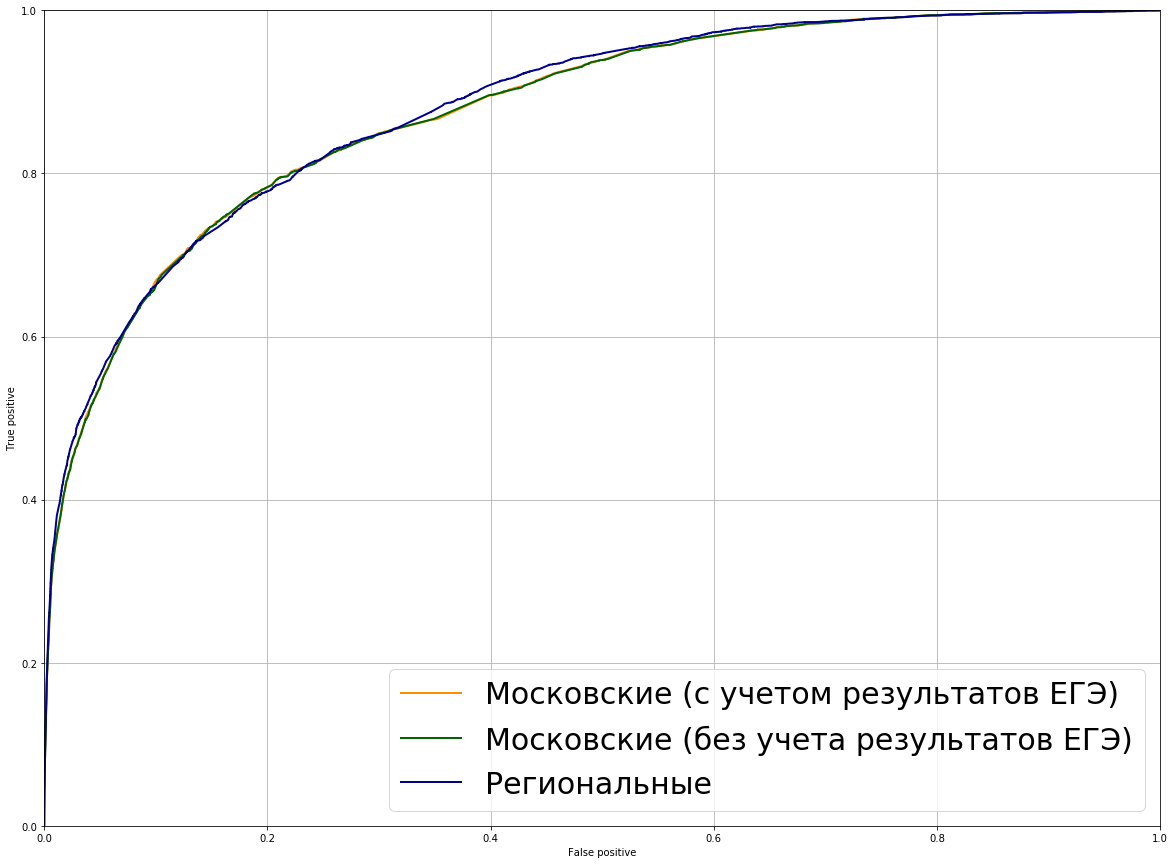

In [19]:
fig = plt.figure(figsize=(20, 15))

# Московские (с учетом результатов ЕГЭ)
fpr_moscow, tpr_moscow, _ = roc_curve(y_test_moscow_with_ege_results, y_pred_moscow_with_ege_results[:, 1])
plt.plot(fpr_moscow, tpr_moscow, color='darkorange', lw=2, label='Московские (с учетом результатов ЕГЭ)')

# Московские (без учета результатов ЕГЭ)
fpr_moscow_no_ege, tpr_moscow_no_ege, _ = roc_curve(y_test_moscow_no_ege_results, y_pred_moscow_no_ege_results[:, 1])
plt.plot(fpr_moscow_no_ege, tpr_moscow_no_ege, color='darkgreen', lw=2, label='Московские (без учета результатов ЕГЭ)')

# Региональные
fpr_regions, tpr_regions, _ = roc_curve(y_test_regions, y_pred_regions[:, 1])
plt.plot(fpr_regions, tpr_regions, color='darkblue', lw=2, label='Региональные')


plt.ylim([0, 1])
plt.xlim([0, 1])
ax = plt.axes()        
ax.yaxis.grid()
ax.xaxis.grid()
ax.set_ylabel('True positive')
ax.set_xlabel('False positive')
plt.legend(loc=4, prop={'size': 30})

In [21]:
def plot_precision_recall(fig, y_test, y_pred, title, i):
    subplot = fig.add_subplot(3,1,i)
    precision, recall, thresholds = precision_recall_curve(y_test, y_pred[:,1])
    plt.step(recall, precision, color='blue', lw=1)
    plt.fill_between(recall, precision, step='pre', alpha=0.2, color='blue')
    plt.ylim([0, 1])
    plt.xlim([0, 1])

    subplot.yaxis.grid()
    subplot.xaxis.grid()
    subplot.set_xticklabels([])
    subplot.set_title(title)

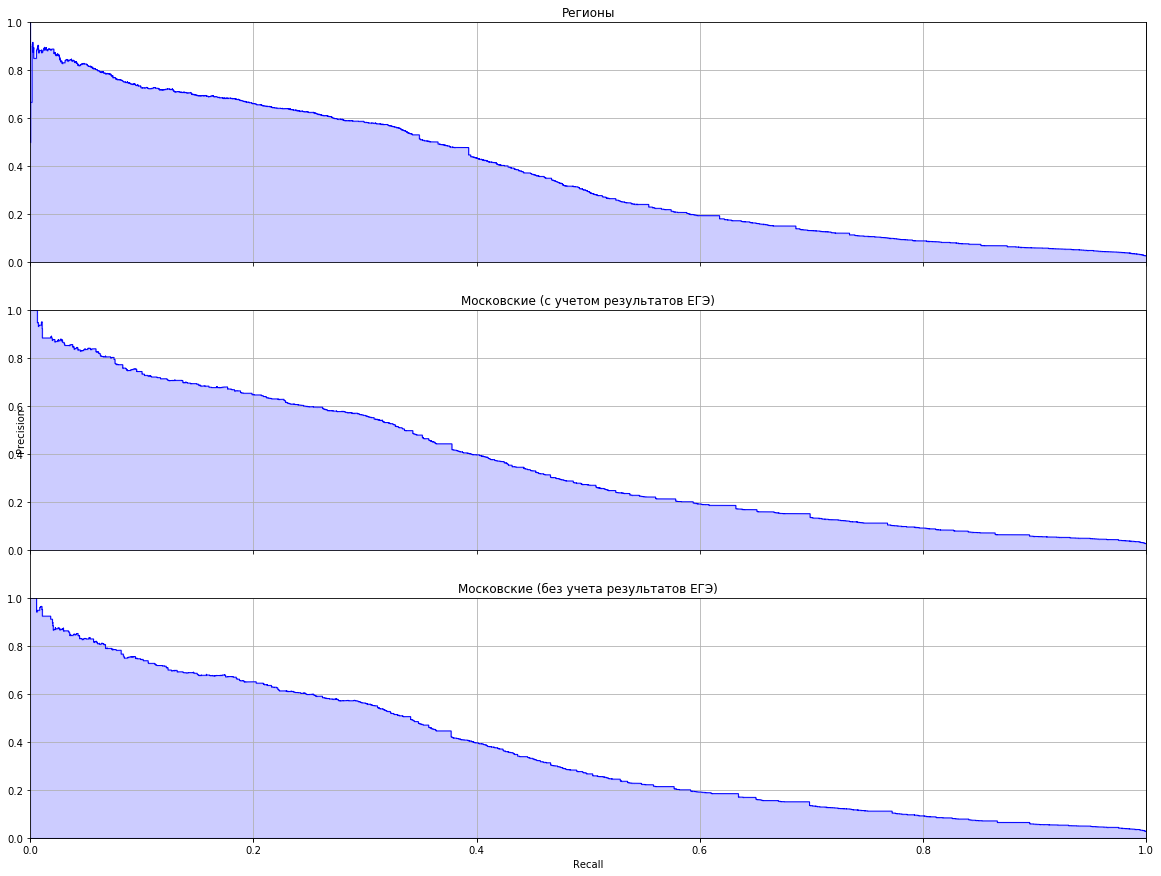

In [22]:
fig = plt.figure(figsize=[20, 15])
ax = plt.axes()
ax.set_yticks([])
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')

plot_precision_recall(fig, y_test_regions, y_pred_regions, 'Регионы', 1)
plot_precision_recall(fig, y_test_moscow_with_ege_results, y_pred_moscow_with_ege_results, 'Московские (с учетом результатов ЕГЭ)', 2)
plot_precision_recall(fig, y_test_moscow_no_ege_results, y_pred_moscow_no_ege_results, 'Московские (без учета результатов ЕГЭ)', 3)